##### Copyright 2020 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Simple audio recognition: Recognizing keywords

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/audio/simple_audio">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/audio/simple_audio.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/audio/simple_audio.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/audio/simple_audio.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial demonstrates how to preprocess audio files in the WAV format and build and train a basic [automatic speech recognition](https://en.wikipedia.org/wiki/Speech_recognition) (ASR) model for recognizing ten different words. You will use a portion of the [Speech Commands dataset](https://www.tensorflow.org/datasets/catalog/speech_commands) ([Warden, 2018](https://arxiv.org/abs/1804.03209)), which contains short (one-second or less) audio clips of commands, such as "down", "go", "left", "no", "right", "stop", "up" and "yes".

Real-world speech and audio recognition [systems](https://ai.googleblog.com/search/label/Speech%20Recognition) are complex. But, like [image classification with the MNIST dataset](../quickstart/beginner.ipynb), this tutorial should give you a basic understanding of the techniques involved.

## Setup

Import necessary modules and dependencies. You'll be using `tf.keras.utils.audio_dataset_from_directory` (introduced in TensorFlow 2.10), which helps generate audio classification datasets from directories of `.wav` files. You'll also need [seaborn](https://seaborn.pydata.org) for visualization in this tutorial.

In [2]:
!pip install -U -q tensorflow tensorflow_datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 89.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.12.0 requires tensorflow==2.19.0, but you have tensorflow 2.20.0 which is incompatible.
tf-keras 2.19.0 requires tensorflow<2.20,>=2.19, but you have tensorflow 2.20.0 which is incompatible.
tensorflow-text 2.19.0 requires tensorflow<2.20,>=2.19.0, but you have tensorflow 2.20.0 which is incompatible.


In [3]:
!pip install -q python_speech_features
from python_speech_features.base import fbank, mfcc

In [4]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

## Import the mini Speech Commands dataset

To save time with data loading, you will be working with a smaller version of the Speech Commands dataset. The [original dataset](https://www.tensorflow.org/datasets/catalog/speech_commands) consists of over 105,000 audio files in the [WAV (Waveform) audio file format](https://www.aelius.com/njh/wavemetatools/doc/riffmci.pdf) of people saying 35 different words. This data was collected by Google and released under a CC BY license.

Download and extract the `mini_speech_commands.zip` file containing the smaller Speech Commands datasets with `tf.keras.utils.get_file`:

In [5]:
DATASET_PATH = 'data/mini_speech_commands_extracted/mini_speech_commands'

data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')

The dataset's audio clips are stored in eight folders corresponding to each speech command: `no`, `yes`, `down`, `go`, `left`, `up`, `right`, and `stop`:

In [6]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[(commands != 'README.md') & (commands != '.DS_Store')]
print('Commands:', commands)

Commands: ['no' 'go' 'stop' 'left' 'down' 'right' 'up' 'yes']


Divided into directories this way, you can easily load the data using `keras.utils.audio_dataset_from_directory`.

The audio clips are 1 second or less at 16kHz. The `output_sequence_length=16000` pads the short ones to exactly 1 second (and would trim longer ones) so that they can be easily batched.

In [7]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=16000,
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 8000 files belonging to 8 classes.
Using 6400 files for training.
Using 1600 files for validation.

label names: ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']


The dataset now contains batches of audio clips and integer labels. The audio clips have a shape of `(batch, samples, channels)`.

In [8]:
train_ds.element_spec

(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

This dataset only contains single channel audio, so use the `tf.squeeze` function to drop the extra axis:

In [9]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

The `utils.audio_dataset_from_directory` function only returns up to two splits. It's a good idea to keep a test set separate from your validation set.
Ideally you'd keep it in a separate directory, but in this case you can use `Dataset.shard` to split the validation set into two halves. Note that iterating over **any** shard will load **all** the data, and only keep its fraction.

In [10]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [11]:
for example_audio, example_labels in train_ds.take(1):
  print(example_audio.shape)
  print(example_labels.shape)

(64, 16000)
(64,)


Let's plot a few audio waveforms:

In [12]:
label_names[[1,1,3,0]]

array(['go', 'go', 'no', 'down'], dtype='<U5')

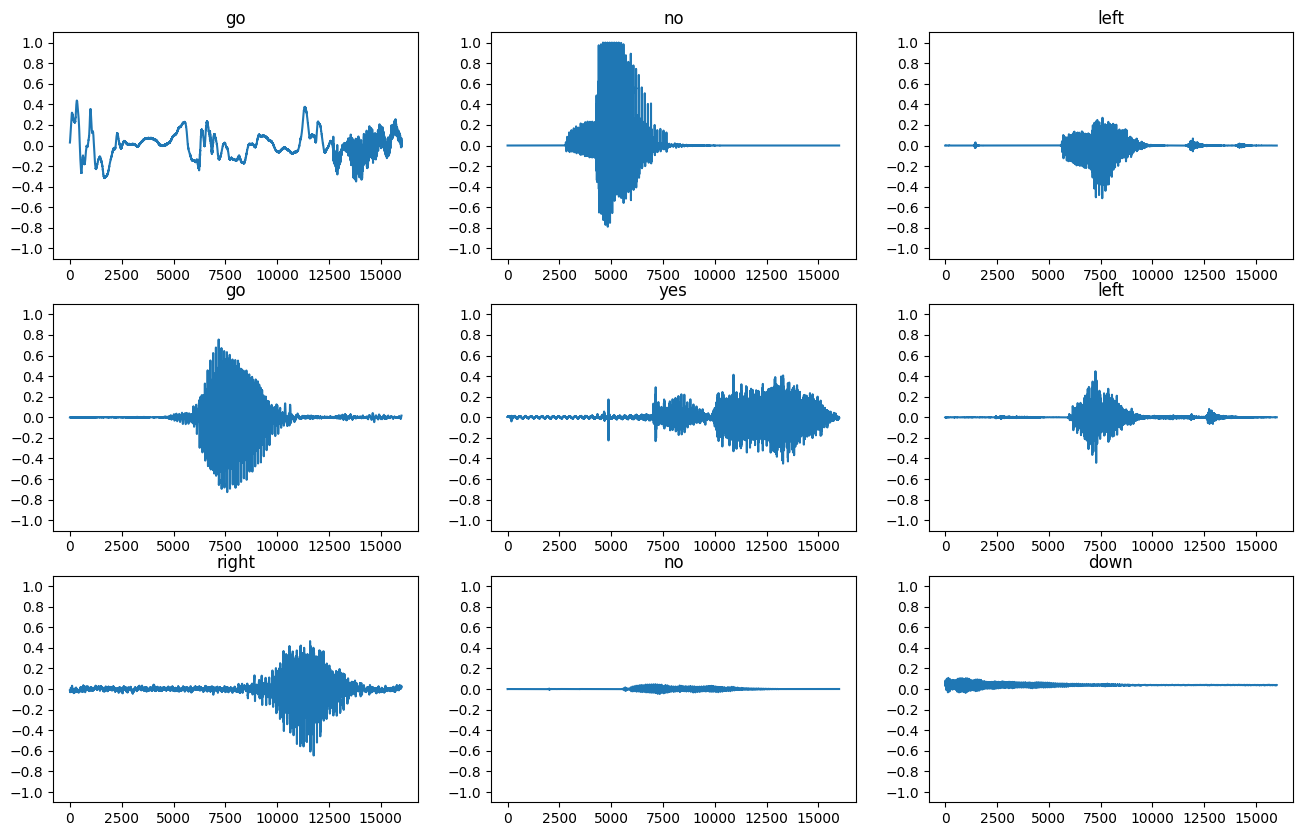

In [13]:
plt.figure(figsize=(16, 10))
rows = 3
cols = 3
n = rows * cols
for i in range(n):
  plt.subplot(rows, cols, i+1)
  audio_signal = example_audio[i]
  plt.plot(audio_signal)
  plt.title(label_names[example_labels[i]])
  plt.yticks(np.arange(-1.2, 1.2, 0.2))
  plt.ylim([-1.1, 1.1])

## Convert waveforms to spectrograms

The waveforms in the dataset are represented in the time domain. Next, you'll transform the waveforms from the time-domain signals into the time-frequency-domain signals by computing the [short-time Fourier transform (STFT)](https://en.wikipedia.org/wiki/Short-time_Fourier_transform) to convert the waveforms to as [spectrograms](https://en.wikipedia.org/wiki/Spectrogram), which show frequency changes over time and can be represented as 2D images. You will feed the spectrogram images into your neural network to train the model.

A Fourier transform (`tf.signal.fft`) converts a signal to its component frequencies, but loses all time information. In comparison, STFT (`tf.signal.stft`) splits the signal into windows of time and runs a Fourier transform on each window, preserving some time information, and returning a 2D tensor that you can run standard convolutions on.

Create a utility function for converting waveforms to spectrograms:

- The waveforms need to be of the same length, so that when you convert them to spectrograms, the results have similar dimensions. This can be done by simply zero-padding the audio clips that are shorter than one second (using `tf.zeros`).
- When calling `tf.signal.stft`, choose the `frame_length` and `frame_step` parameters such that the generated spectrogram "image" is almost square. For more information on the STFT parameters choice, refer to [this Coursera video](https://www.coursera.org/lecture/audio-signal-processing/stft-2-tjEQe) on audio signal processing and STFT.
- The STFT produces an array of complex numbers representing magnitude and phase. However, in this tutorial you'll only use the magnitude, which you can derive by applying `tf.abs` on the output of `tf.signal.stft`.

In [14]:
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

Next, start exploring the data. Print the shapes of one example's tensorized waveform and the corresponding spectrogram, and play the original audio:

In [15]:
for i in range(3):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=16000))

Label: go
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: no
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: left
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Now, define a function for displaying a spectrogram:

In [16]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

Plot the example's waveform over time and the corresponding spectrogram (frequencies over time):

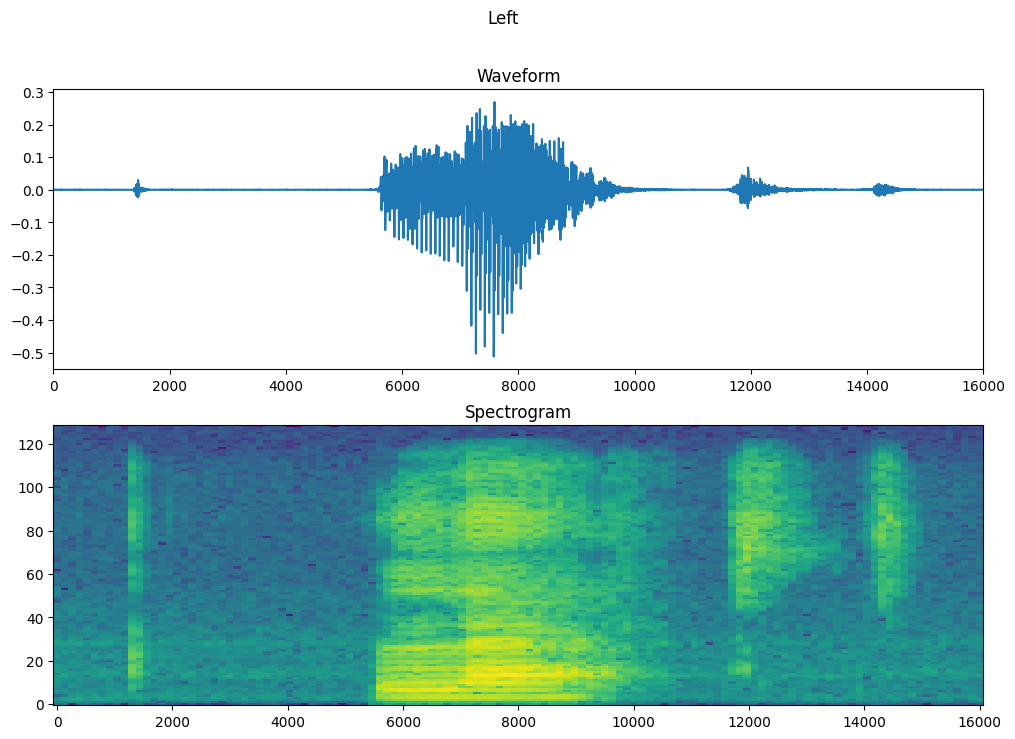

In [17]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

Now, create spectrogram datasets from the audio datasets:

In [18]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [19]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

Get the Mel spectrogram and MFCCs

In [20]:
def _mel_mfcc_np(waveform,
                 sample_rate=16000,
                 nfilt=40,      # Number of Mel filters for fbank
                 numcep=13,     # Number of MFCCs
                 winlen=0.025,
                 winstep=0.01,
                 nfft=512,
                 use_log=True):
  """
  Input:
    waveform: (float) 1D array, 16 000 samples
  Returns:
    mel_spec: (float) [T, nfilt]
    mfccs:    (float) [T, numcep]
  """
  # Ensure input type as float32
  x = np.asarray(waveform, dtype=np.float32)

  # Fbank energies
  mel_fbanks, _ = fbank(x,
                        samplerate=sample_rate,
                        nfilt=nfilt,
                        winlen=winlen,
                        winstep=winstep,
                        nfft=nfft)

  if use_log:
    mel = np.log(mel_fbanks + np.finfo(np.float32).eps).astype(np.float32)
  else:
    mel = mel_fbanks.astype(np.float32)

  mfccs = mfcc(x,
               samplerate=sample_rate,
               numcep=numcep,
               nfilt=nfilt,
               winlen=winlen,
               winstep=winstep,
               nfft=nfft).astype(np.float32)

  # Defensive, but ensure alignment of frames
  T = min(mel.shape[0], mfccs.shape[0])
  mel, mfccs = mel[:T], mfccs[:T]
  return mel, mfccs

# Wrapper that returns tensors
def waveform_to_mel_mfcc(waveform, nfilt=40, numcep=13):
  mel, mfccs = tf.numpy_function(
      func=_mel_mfcc_np,
      inp=[waveform],
      Tout=(tf.float32, tf.float32)
  )

  # Set partial shapes
  mel = tf.ensure_shape(mel, [None, nfilt])
  mfccs = tf.ensure_shape(mfccs, [None, numcep])

  # Adding channel axis; image-like (time, freq, channels)
  mel = mel[..., tf.newaxis]      # (T, nfilt, 1)
  mfccs = mfccs[..., tf.newaxis]  # (T, numcep, 1)
  return mel, mfccs

Modified make_spec_ds function that includes all input features.

In [33]:
def make_spec_ds(ds, feature_type='spectrogram', nfilt=40, numcep=13):
  def map_fn(audio, label):
    if feature_type== 'spectrogram':
      spec = get_spectrogram(audio) # (T, F, 1)
      return spec, label

    elif feature_type == 'mel':
      mel, _ = waveform_to_mel_mfcc(audio, nfilt=nfilt, numcep=numcep)  # (T, nfilt, 1)
      return mel, label

    elif feature_type == 'mfcc':
      _, mfccs = waveform_to_mel_mfcc(audio, nfilt=nfilt, numcep=numcep)  # (T, numcep, 1)
      return mfccs, label

    elif feature_type == 'mel+mfcc':
      mel, mffcs = waveform_to_mel_mfcc(audio, nfilt=nfilt, numcep=numcep)  # (T, nfilt, 1), (T, numcep, 1)
      # Pad MFCC frequency axis; numcep -> nfilt
      pad = tf.maximum(0, nfilt - numcep)
      mfccs_padded = tf.pad(mfccs, paddings=[[0,0], [0, pad], [0, 0]])
      feat = tf.concat([mel, mfccs_padded], axis=-1)  # (T, nfilt, 2)
      return feat, label

    else:
      raise ValueError(f'Unknown feature_type: {feature_type}')

  return ds.map(map_fn, num_parallel_calls=tf.data.AUTOTUNE)

# NEW DS FUNC
def make_spec_ds(ds, feature_type='spectrogram', nfilt=40, numcep=13):
    """
    feature_type ∈ {'spectrogram', 'mel', 'mfcc', 'mel+mfcc'}
    Returns a dataset yielding (features, label) where features is rank-4:
      (batch, time, freq, channels)
    """
    def map_batched(audio, label):
        if feature_type == 'spectrogram':
            # Original path: vectorized over batches
            spec = get_spectrogram(audio)  # (batch, T, F, 1)
            return spec, label

        # Per-example feature extraction for python_speech_features
        def per_example(x):
            mel_x, mfcc_x = waveform_to_mel_mfcc(x, nfilt=nfilt, numcep=numcep)
            return mel_x, mfcc_x

        mel_batch, mfcc_batch = tf.map_fn(
            per_example, audio,
            fn_output_signature=(
                tf.TensorSpec(shape=(None, nfilt, 1),  dtype=tf.float32),
                tf.TensorSpec(shape=(None, numcep, 1), dtype=tf.float32),
            )
        )  # shapes: (batch, T, nfilt, 1) and (batch, T, numcep, 1)

        if feature_type == 'mel':
            return mel_batch, label

        if feature_type == 'mfcc':
            return mfcc_batch, label

        if feature_type == 'mel+mfcc':
            pad = tf.maximum(0, nfilt - numcep)
            # Pad MFCCs along the frequency axis to match nfilt, then concat as channels
            mfcc_padded = tf.pad(mfcc_batch, paddings=[[0,0],[0,0],[0,pad],[0,0]])  # (batch, T, nfilt, 1)
            feat = tf.concat([mel_batch, mfcc_padded], axis=-1)  # (batch, T, nfilt, 2)
            return feat, label

        raise ValueError(f"Unknown feature_type: {feature_type}")

    return ds.map(map_batched, num_parallel_calls=tf.data.AUTOTUNE)


Build additional datasets:

In [38]:

# Baseline (unchanged)
train_spec_ds = make_spec_ds(train_ds, feature_type='spectrogram')
val_spec_ds   = make_spec_ds(val_ds,   feature_type='spectrogram')
test_spec_ds  = make_spec_ds(test_ds,  feature_type='spectrogram')

# Log-Mel Spectrograms
train_mel_ds = make_spec_ds(train_ds, feature_type='mel', nfilt=40)
val_mel_ds   = make_spec_ds(val_ds,   feature_type='mel', nfilt=40)
test_mel_ds  = make_spec_ds(test_ds,  feature_type='mel', nfilt=40)

# MFCC
train_mfcc_ds = make_spec_ds(train_ds, feature_type='mfcc', nfilt=40, numcep=13)
val_mfcc_ds   = make_spec_ds(val_ds,   feature_type='mfcc', nfilt=40, numcep=13)
test_mfcc_ds  = make_spec_ds(test_ds,  feature_type='mfcc', nfilt=40, numcep=13)

# Mel + MFCC

train_mel_mfcc_ds = make_spec_ds(train_ds, feature_type='mel+mfcc', nfilt=40, numcep=13)
val_mel_mfcc_ds   = make_spec_ds(val_ds,   feature_type='mel+mfcc', nfilt=40, numcep=13)
test_mel_mfcc_ds  = make_spec_ds(test_ds,  feature_type='mel+mfcc', nfilt=40, numcep=13)


def prep(ds): return ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
def prep_eval(ds): return ds.cache().prefetch(tf.data.AUTOTUNE)


train_spec_ds = prep(train_spec_ds);  val_spec_ds = prep_eval(val_spec_ds);  test_spec_ds = prep_eval(test_spec_ds)
train_mel_ds  = prep(train_mel_ds);   val_mel_ds  = prep_eval(val_mel_ds);   test_mel_ds  = prep_eval(test_mel_ds)
train_mfcc_ds = prep(train_mfcc_ds);  val_mfcc_ds = prep_eval(val_mfcc_ds);  test_mfcc_ds = prep_eval(test_mfcc_ds)
train_mel_mfcc_ds = prep(train_mel_mfcc_ds); val_mel_mfcc_ds = prep_eval(val_mel_mfcc_ds); test_mel_mfcc_ds = prep_eval(test_mel_mfcc_ds)


Examine the spectrograms for different examples of the dataset:

In [23]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

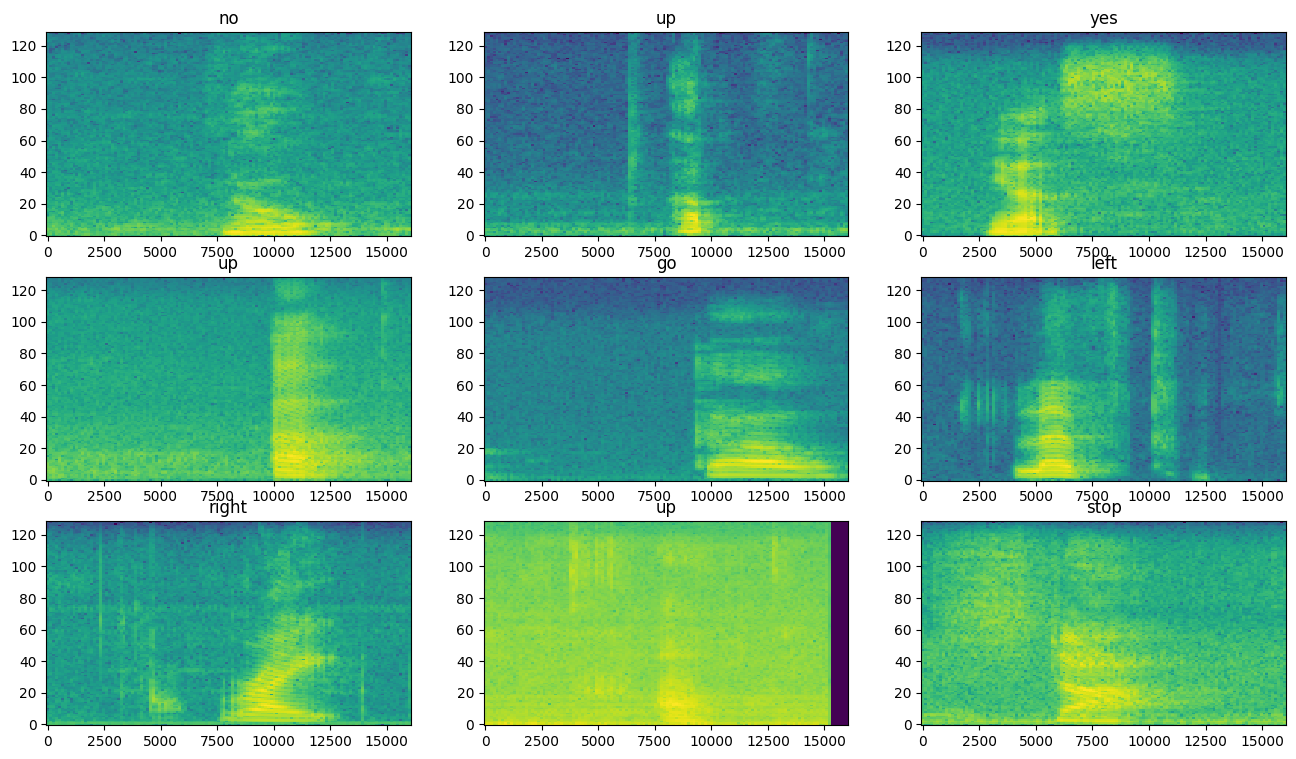

In [24]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

plt.show()

## Build and train the model

Add `Dataset.cache` and `Dataset.prefetch` operations to reduce read latency while training the model:

In [25]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

For the model, you'll use a simple convolutional neural network (CNN), since you have transformed the audio files into spectrogram images.

Your `tf.keras.Sequential` model will use the following Keras preprocessing layers:

- `tf.keras.layers.Resizing`: to downsample the input to enable the model to train faster.
- `tf.keras.layers.Normalization`: to normalize each pixel in the image based on its mean and standard deviation.

For the `Normalization` layer, its `adapt` method would first need to be called on the training data in order to compute aggregate statistics (that is, the mean and the standard deviation).

In [26]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (124, 129, 1)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing (Resizing)             │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization (Normalization)   │ (None, 32, 32, 1)      │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,625,611 (6.20 MB)

 Trainable params: 1,625,608 (6.20 MB)

 Non-trainable params: 3 (16.00 B)

In [39]:
# NEW MODE BUILD ADAPTED
from tensorflow.keras import layers, models
# sanity check:

for xb, yb in train_mel_ds.take(1):
    print("mel batch:", xb.shape, yb.shape)  # expect (batch, T, nfilt, 1), e.g. (64, 99, 40, 1)
    break


def build_model(train_features_ds, num_labels):
  # infer shape from looking at data
  for example_features, _ in train_features_ds.take(1):
    input_shape = example_features.shape[1:]
  print("Input shape: ", input_shape)

  # norm layer must adapt to input features
  norm = layers.Normalization()
  norm.adapt(train_features_ds.map(lambda x, y: x))

  model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
  ])

  model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
  )

  return model


num_labels = len(label_names)

mel batch: (64, 99, 40, 1) (64,)



----- STFT Spectrogram -----
Input shape:  (124, 129, 1)
Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.2671 - loss: 1.9353 - val_accuracy: 0.6081 - val_loss: 1.2950
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5486 - loss: 1.2829 - val_accuracy: 0.7031 - val_loss: 0.9528
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6626 - loss: 0.9503 - val_accuracy: 0.7669 - val_loss: 0.7290
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7255 - loss: 0.7813 - val_accuracy: 0.7917 - val_loss: 0.6719
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7768 - loss: 0.6450 - val_accuracy: 0.8073 - val_loss: 0.6037
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7966 - loss: 0.5697 - val_accuracy: 0.8151 - val_loss: 0.5607
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8286 - loss: 0.4905 - val_accuracy: 0.8229 - val_loss: 0.5444
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7m

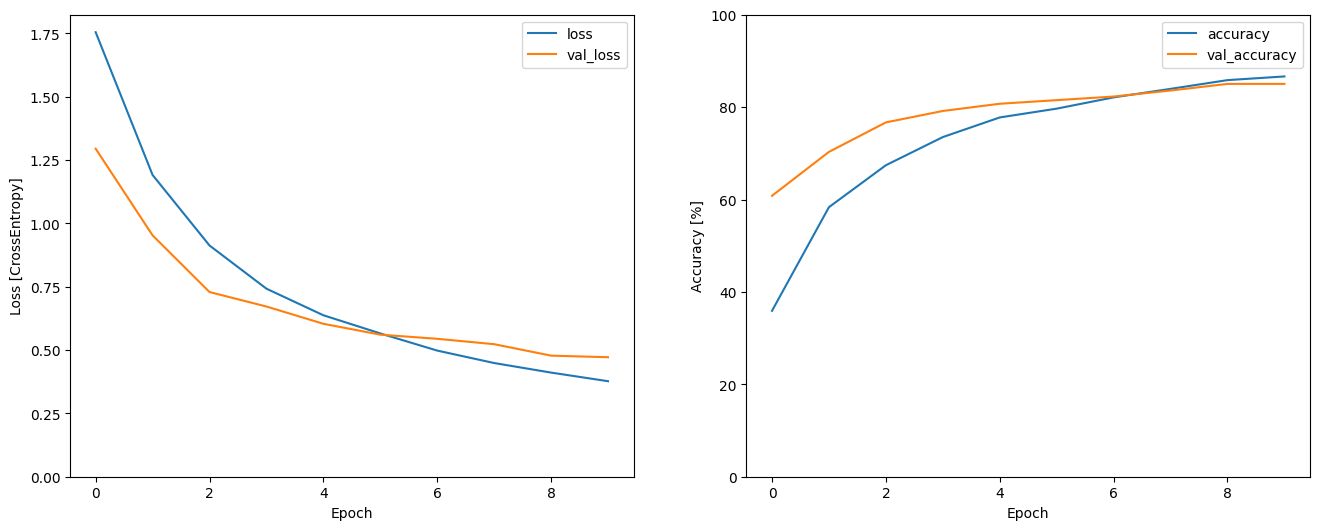

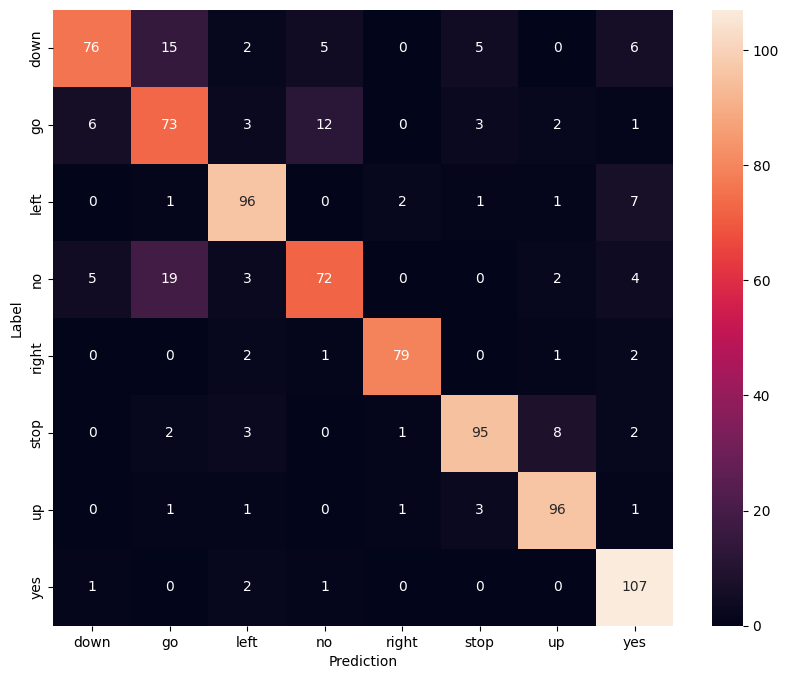


----- Log-Mel -----
Input shape:  (99, 40, 1)
Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.2248 - loss: 3.0504 - val_accuracy: 0.6888 - val_loss: 0.9796
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6538 - loss: 1.0042 - val_accuracy: 0.7930 - val_loss: 0.6504
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7506 - loss: 0.7365 - val_accuracy: 0.8125 - val_loss: 0.5975
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7855 - loss: 0.5886 - val_accuracy: 0.8503 - val_loss: 0.4630
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8336 - loss: 0.4713 - val_accuracy: 0.8659 - val_loss: 0.4289
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8571 - loss: 0.3935 - val_accuracy: 0.8815 - val_loss: 0.3771
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8845 - loss: 0.3308 - val_accuracy: 0.8880 - val_loss: 0.3490
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - ac

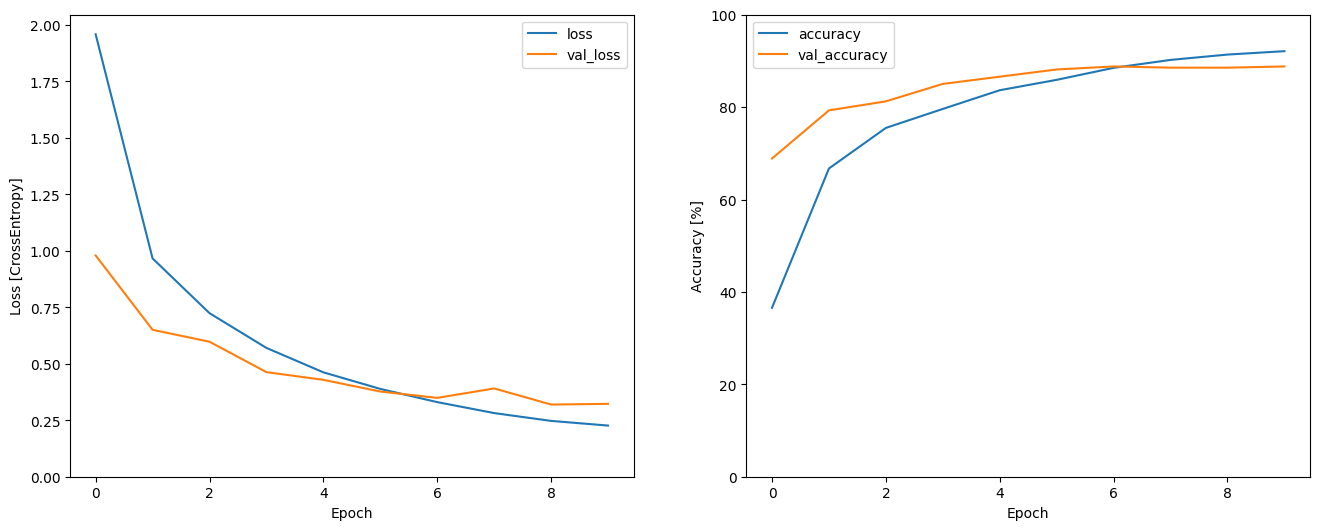

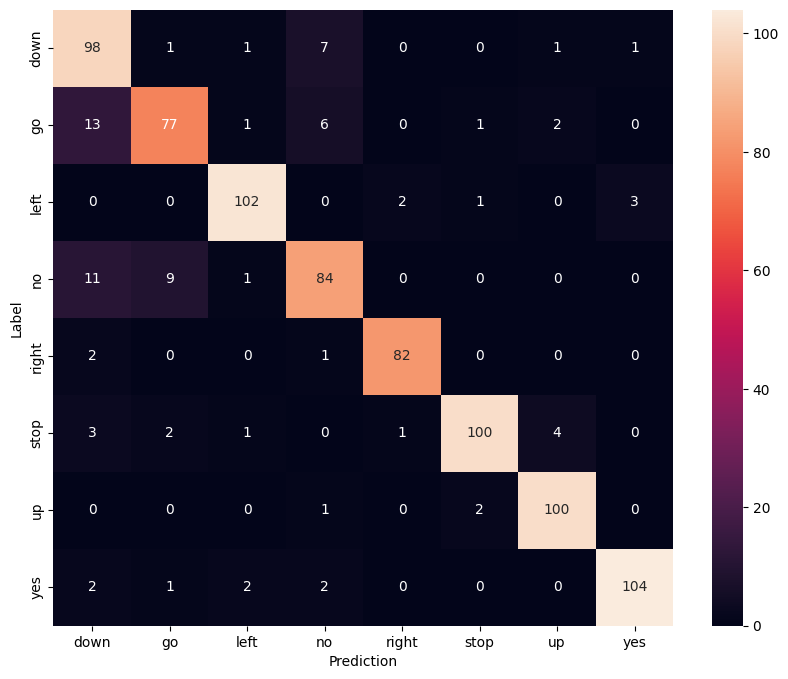


----- MFCC -----
Input shape:  (99, 13, 1)
Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.1888 - loss: 3.7555 - val_accuracy: 0.5482 - val_loss: 1.2710
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4556 - loss: 1.4302 - val_accuracy: 0.7383 - val_loss: 0.8936
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5881 - loss: 1.0894 - val_accuracy: 0.7708 - val_loss: 0.7126
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6579 - loss: 0.9078 - val_accuracy: 0.8047 - val_loss: 0.6045
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7198 - loss: 0.7546 - val_accuracy: 0.8021 - val_loss: 0.5783
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7548 - loss: 0.6625 - val_accuracy: 0.8164 - val_loss: 0.5241
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7817 - loss: 0.5825 - val_accuracy: 0.8307 - val_loss: 0.4989
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accur

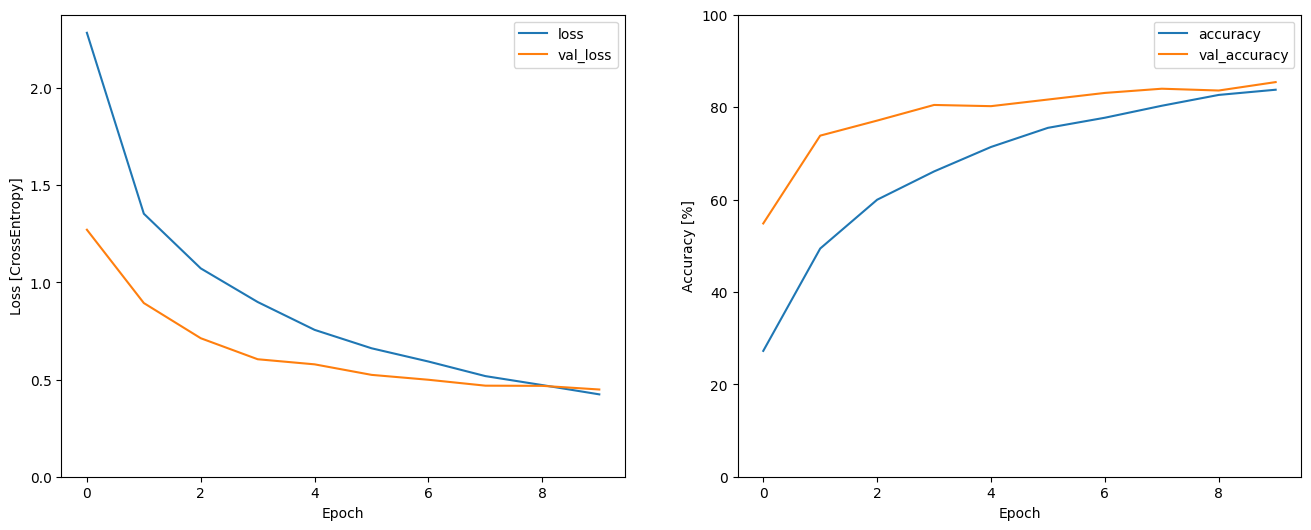

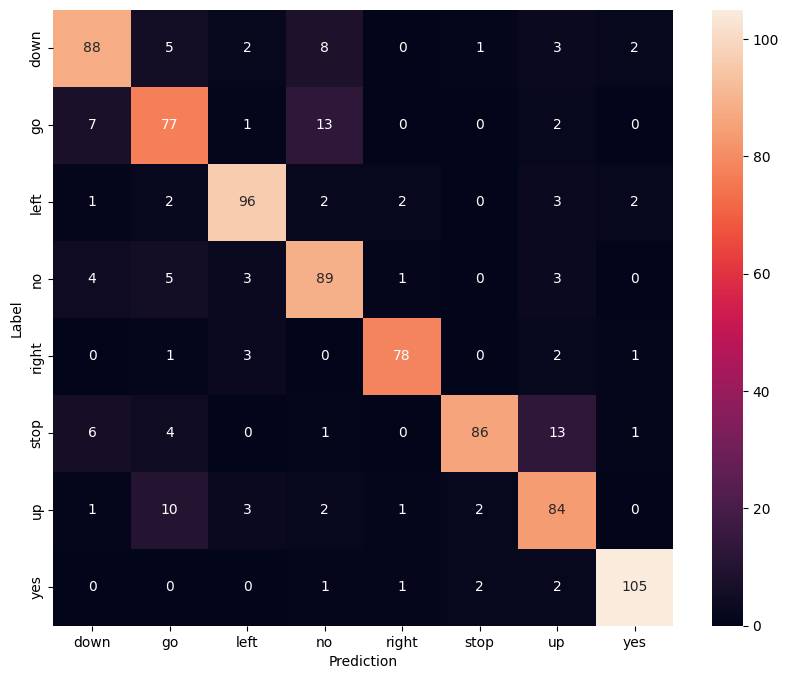


----- Log-Mel + MFCC (2ch) -----
Input shape:  (99, 40, 2)
Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.1922 - loss: 4.7389 - val_accuracy: 0.6016 - val_loss: 1.2492
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5415 - loss: 1.2918 - val_accuracy: 0.7734 - val_loss: 0.7547
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7092 - loss: 0.8578 - val_accuracy: 0.8151 - val_loss: 0.5974
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7687 - loss: 0.6544 - val_accuracy: 0.8529 - val_loss: 0.5011
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8183 - loss: 0.5138 - val_accuracy: 0.8555 - val_loss: 0.4366
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8534 - loss: 0.4352 - val_accuracy: 0.8516 - val_loss: 0.4171
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8656 - loss: 0.3767 - val_accuracy: 0.8659 - val_loss: 0.4097
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 

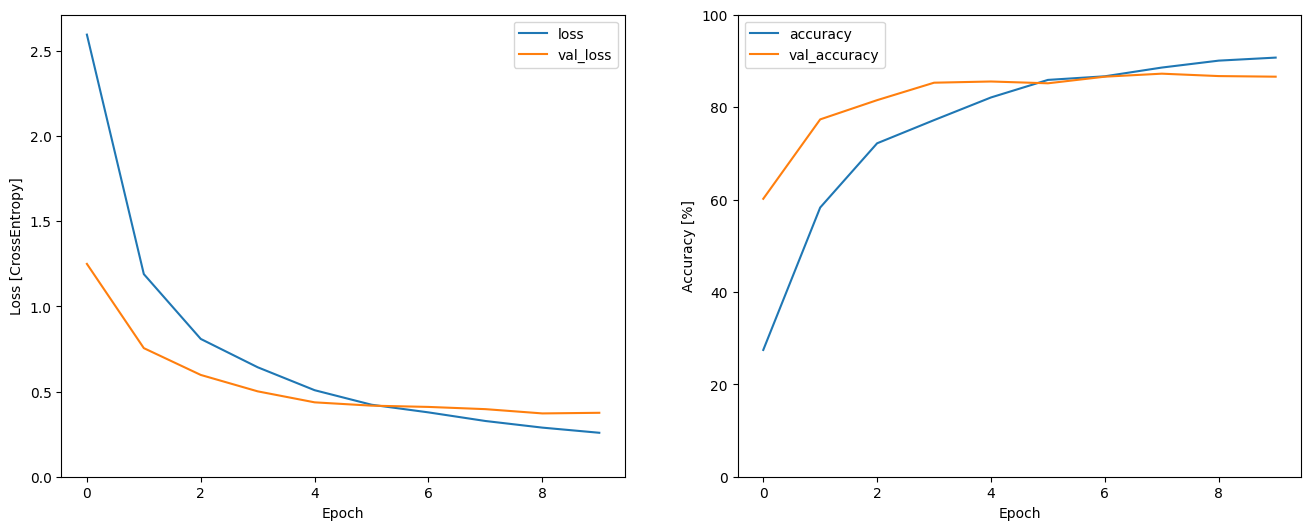

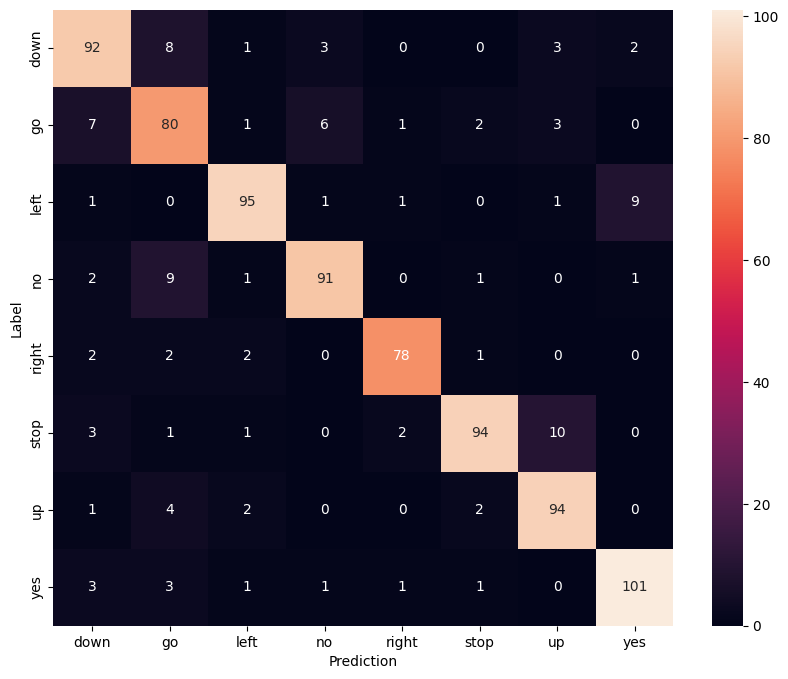

In [42]:
EPOCHS = 10
# TRAINING MODEL AND COMPARING
def train_eval(name, train_ds, val_ds, test_ds):
  print(f"\n----- {name} -----")
  model = build_model(train_ds, num_labels)
  history = model.fit(
      train_ds,
      validation_data=val_ds,
      epochs=EPOCHS,
      callbacks=[tf.keras.callbacks.EarlyStopping(verbose=1, patience=2)]
  )

  # Plotting loss and accuracy
  metrics = history.history
  plt.figure(figsize=(16,6))
  plt.subplot(1,2,1)
  plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
  plt.legend(['loss', 'val_loss'])
  plt.ylim([0, max(plt.ylim())])
  plt.xlabel('Epoch')
  plt.ylabel('Loss [CrossEntropy]')

  plt.subplot(1,2,2)
  plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
  plt.legend(['accuracy', 'val_accuracy'])
  plt.ylim([0, 100])
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy [%]')

  test_metrics = model.evaluate(test_ds, return_dict=True)
  print(f"Test accuracy for {name}: {test_metrics['accuracy']:.4f}")

  # Confusion matrix
  y_pred = model.predict(test_ds)
  y_pred = tf.argmax(y_pred, axis=1)
  y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

  confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
  plt.figure(figsize=(10, 8))
  sns.heatmap(confusion_mtx,
              xticklabels=label_names,
              yticklabels=label_names,
              annot=True, fmt='g')
  plt.xlabel('Prediction')
  plt.ylabel('Label')
  plt.show()


  return model, history, test_metrics

spec_model, spec_hist, spec_test = train_eval("STFT Spectrogram", train_spec_ds, val_spec_ds, test_spec_ds)
mel_model,  mel_hist,  mel_test  = train_eval("Log-Mel",          train_mel_ds,  val_mel_ds,  test_mel_ds)
mfcc_model, mfcc_hist, mfcc_test = train_eval("MFCCs",             train_mfcc_ds, val_mfcc_ds, test_mfcc_ds)
melmfcc_model, melmfcc_hist, melmfcc_test = train_eval("Log-Mel + MFCC (2ch)", train_mel_mfcc_ds, val_mel_mfcc_ds, test_mel_mfcc_ds)


Configure the Keras model with the Adam optimizer and the cross-entropy loss:

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

Train the model over 10 epochs for demonstration purposes:

In [ ]:
EPOCHS = 10
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Let's plot the training and validation loss curves to check how your model has improved during training:

In [41]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

NameError: name 'history' is not defined

## Evaluate the model performance

Run the model on the test set and check the model's performance:

In [ ]:
model.evaluate(test_spectrogram_ds, return_dict=True)

### Display a confusion matrix

Use a [confusion matrix](https://developers.google.com/machine-learning/glossary#confusion-matrix) to check how well the model did classifying each of the commands in the test set:


In [ ]:
y_pred = model.predict(test_spectrogram_ds)

In [ ]:
y_pred = tf.argmax(y_pred, axis=1)

In [ ]:
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

In [ ]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

## Run inference on an audio file

Finally, verify the model's prediction output using an input audio file of someone saying "no". How well does your model perform?

In [ ]:
x = data_dir/'no/01bb6a2a_nohash_0.wav'
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis,...]

prediction = model(x)
x_labels = ['no', 'yes', 'down', 'go', 'left', 'up', 'right', 'stop']
plt.bar(x_labels, tf.nn.softmax(prediction[0]))
plt.title('No')
plt.show()

display.display(display.Audio(waveform, rate=16000))

As the output suggests, your model should have recognized the audio command as "no".

## Export the model with preprocessing

The model's not very easy to use if you have to apply those preprocessing steps before passing data to the model for inference. So build an end-to-end version:

In [ ]:
class ExportModel(tf.Module):
  def __init__(self, model):
    self.model = model

    # Accept either a string-filename or a batch of waveforms.
    # You could add additional signatures for a single wave, or a ragged-batch.
    self.__call__.get_concrete_function(
        x=tf.TensorSpec(shape=(), dtype=tf.string))
    self.__call__.get_concrete_function(
       x=tf.TensorSpec(shape=[None, 16000], dtype=tf.float32))


  @tf.function
  def __call__(self, x):
    # If they pass a string, load the file and decode it.
    if x.dtype == tf.string:
      x = tf.io.read_file(x)
      x, _ = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
      x = tf.squeeze(x, axis=-1)
      x = x[tf.newaxis, :]

    x = get_spectrogram(x)
    result = self.model(x, training=False)

    class_ids = tf.argmax(result, axis=-1)
    class_names = tf.gather(label_names, class_ids)
    return {'predictions':result,
            'class_ids': class_ids,
            'class_names': class_names}

Test run the "export" model:

In [ ]:
export = ExportModel(model)
export(tf.constant(str(data_dir/'no/01bb6a2a_nohash_0.wav')))

Save and reload the model, the reloaded model gives identical output:

In [ ]:
tf.saved_model.save(export, "saved")
imported = tf.saved_model.load("saved")
imported(waveform[tf.newaxis, :])

## Next steps

This tutorial demonstrated how to carry out simple audio classification/automatic speech recognition using a convolutional neural network with TensorFlow and Python. To learn more, consider the following resources:

- The [Sound classification with YAMNet](https://www.tensorflow.org/hub/tutorials/yamnet) tutorial shows how to use transfer learning for audio classification.
- The notebooks from [Kaggle's TensorFlow speech recognition challenge](https://www.kaggle.com/c/tensorflow-speech-recognition-challenge/overview).
- The
[TensorFlow.js - Audio recognition using transfer learning codelab](https://codelabs.developers.google.com/codelabs/tensorflowjs-audio-codelab/index.html#0) teaches how to build your own interactive web app for audio classification.
- [A tutorial on deep learning for music information retrieval](https://arxiv.org/abs/1709.04396) (Choi et al., 2017) on arXiv.
- TensorFlow also has additional support for [audio data preparation and augmentation](https://www.tensorflow.org/io/tutorials/audio) to help with your own audio-based projects.
- Consider using the [librosa](https://librosa.org/) library for music and audio analysis.